In [15]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import pickle
import os
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.io import output_notebook 
output_notebook

<function bokeh.io.output.output_notebook(resources: 'Resources | None' = None, verbose: 'bool' = False, hide_banner: 'bool' = False, load_timeout: 'int' = 5000, notebook_type: 'NotebookType' = 'jupyter') -> 'None'>

Подгружаем очищенную выборку

In [ ]:
df = pd.read_pickle('/Users/Desktop/LR1_IIS/data/clean_car_data.pkl').sample(frac=0.1, random_state = 2) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 99 to 3
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Car_Name       30 non-null     category
 1   Year           30 non-null     int16   
 2   Selling_Price  30 non-null     float16 
 3   Present_Price  30 non-null     float16 
 4   Driven_kms     30 non-null     int16   
 5   Fuel_Type      30 non-null     object  
 6   Selling_type   30 non-null     category
 7   Transmission   30 non-null     category
 8   Owner          30 non-null     int16   
 9   Fuel_type      30 non-null     category
dtypes: category(4), float16(2), int16(3), object(1)
memory usage: 1.7+ KB


In [17]:
df = df.rename(columns={'Present_Price': 'target'})
df = df.drop(columns=['Year'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=100)

In [19]:
df

,Car_Name,Selling_Price,target,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Fuel_type
99,fortuner,9.648438,20.453125,-15512,Diesel,Dealer,Manual,0,Diesel
161,TVS Apache RTR 180,0.449951,0.826172,23000,Petrol,Individual,Manual,0,Petrol
89,etios g,4.750000,6.761719,-25536,Petrol,Dealer,Manual,0,Petrol
30,ritz,3.099609,5.980469,-14097,Diesel,Dealer,Manual,0,Diesel
232,elantra,11.453125,14.789062,12900,Petrol,Dealer,Automatic,0,Petrol
290,amaze,4.500000,6.398438,19000,Petrol,Dealer,Manual,0,Petrol
35,sx4,2.949219,7.738281,-15538,CNG,Dealer,Manual,0,CNG
7,s cross,6.500000,8.609375,-32107,Diesel,Dealer,Manual,0,Diesel
183,Bajaj Discover 100,0.270020,0.469971,21000,Petrol,Individual,Manual,0,Petrol
13,ertiga,6.101562,7.710938,26000,Petrol,Dealer,Manual,0,Petrol


In [20]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission', 'Fuel_type']

In [21]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Selling_Price', 'Driven_kms', 'Owner']

In [22]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) 
regressor=RandomForestRegressor()


In [23]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [24]:

pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Selling_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'Fuel_type'])])),
                ('model', RandomForestRegressor())])

In [25]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 1.3552642822265626,
 'mape': 1.0099020223129362,
 'mse': 2.521910568973422}

Работаем с MLflow локально

In [31]:

# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5001

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [27]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "car_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "car_model_rf"

In [ ]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)
req_file = '../requirements.txt'
params_dict = pipeline.get_params()


In [29]:
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

In [30]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/12/04 18:02:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/f307e1b1b8824d6c8b5d9d8641d4b5a7.
2024/12/04 18:02:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [ ]:
#mlflow.delete_run('aead09fbc6b6454ea70b5318fc675a2e')

ПУНКТ 10

In [32]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer


X_train_fe_sklearn = X_train.copy()
X_test_fe_sklearn = X_test.copy()

num_features = ['Selling_Price', 'Driven_kms']

pf = PolynomialFeatures(degree=2)

kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')



preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('poly', Pipeline([
                            ('poly_feat', pf),
                            ('scaler', s_scaler)]), num_features),
        ('k_bin', kbd, num_features)
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования


X_train_sklearn = preprocessor_sklearn.fit_transform(X_train_fe_sklearn)
X_test_sklearn = preprocessor_sklearn.fit_transform(X_test_fe_sklearn)

In [33]:
X_train_sklearn_df = pd.DataFrame(X_train_sklearn, columns = preprocessor_sklearn.get_feature_names_out())

X_test_sklearn_df = pd.DataFrame(X_test_sklearn, columns = preprocessor_sklearn.get_feature_names_out())


In [34]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', regressor)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

predictions = pipeline_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 1.1901797485351564,
 'mape': 0.8483082692251778,
 'mse': 1.829586425941438}

In [35]:
# Посмотрим на тренировочные данные

transformed_data = pipeline_sklearn.named_steps['transform'].transform(X_train)

import pandas as pd
transformed_df = pd.DataFrame(transformed_data, columns=pipeline_sklearn.named_steps['transform'].get_feature_names_out())

display(transformed_df.head())
print(transformed_df.shape)

,num__Selling_Price,num__Driven_kms,cat__Car_Name,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__Fuel_type,poly__1,poly__Selling_Price,poly__Driven_kms,poly__Selling_Price^2,poly__Selling_Price Driven_kms,poly__Driven_kms^2,k_bin__Selling_Price,k_bin__Driven_kms
0,-0.353686,-0.920101,18.0,0.0,0.0,1.0,0.0,0.0,-0.353686,-0.920101,-0.550469,-0.378276,-0.206737,0.0,0.0
1,-1.004190,0.838174,6.0,2.0,1.0,1.0,2.0,0.0,-1.004190,0.838174,-0.743635,0.112884,-0.262953,0.0,2.0
2,-1.012101,0.780598,2.0,2.0,1.0,1.0,2.0,0.0,-1.012101,0.780598,-0.744272,0.104544,-0.362183,0.0,2.0
3,0.120717,-1.207869,13.0,1.0,0.0,1.0,1.0,0.0,0.120717,-1.207869,-0.234183,-0.857361,0.410189,1.0,0.0
4,1.886609,0.717264,11.0,2.0,0.0,0.0,2.0,0.0,1.886609,0.717264,2.243520,1.414739,-0.463431,2.0,2.0


(22, 15)


In [36]:
# имена столбцов
col_names = preprocessor_sklearn.get_feature_names_out()
pd.DataFrame(col_names).to_csv("column_names.csv", index=False) # Сохраняем в файл

In [37]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'Feature Importances'

input_example = X_train_sklearn_df.head(5)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = pipeline.get_params()

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('column_names.csv', artifact_path = 'columns')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/12/04 18:05:17 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__Selling_Price",
      "num__Driven_kms",
      "cat__Car_Name",
      "cat__Fuel_Type",
      "cat__Selling_type",
      "cat__Transmission",
      "cat__Fuel_type",
      "poly__1",
      "poly__Selling_Price",
      "poly__Driven_kms",
      "poly__Selling_Price^2",
      "poly__Selling_Price Driven_kms",
      "poly__Driven_kms^2",
      "k_bin__Selling_Price",
      "k_bin__Driven_kms"
    ],
    "data": [
      [
        -0.3536859452724457,
        -0.9201006889343262,
        18.0,
        0.0,
        0.0,
        1.0,
        0.0,
        0.0,
        -0.3536859452724457,
        -0.9201006889343262,
        -0.5504694581031799,
        -0.3782762289047241,
        -0.2067367434501648,
        0.0,
        0.0
      ],
      [
        -1.0041897296905518,
        0.8381744623184204,
        6.0,
        2.0,
        1.0,
        1.0,
 

ПУНКТ 12

Выбранные индексы: [0, 1, 2, 3, 5, 6, 7, 8, 11, 14, 15, 23, 24, 27, 28, 31]
Выбранные признаки: ['0', '1', '2', '3', '5', '6', '7', '8', '11', '14', '15', '23', '24', '27', '28', '31']


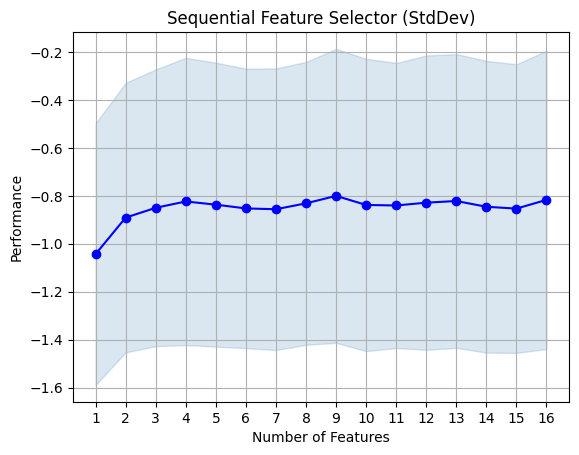

Метрики: {'mae': 0.4332747802734376, 'mape': 0.1179405263925043, 'mse': 0.4324183127309682}


In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Обновлённые списки признаков
categorical_features = ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Fuel_type']
numerical_features = ['Selling_Price', 'Driven_kms']


# Настройка ColumnTransformer с OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # Игнорируем неизвестные категории
        ('num', 'passthrough', numerical_features)
    ]
)

# Преобразование данных
X_train_fe_sklearn = preprocessor.fit_transform(X_train)
X_test_fe_sklearn = preprocessor.transform(X_test)

# Sequential Feature Selector
model = RandomForestRegressor(n_estimators=100, random_state=42)
sfs = SFS(
    estimator=model,
    k_features=int(X_train_fe_sklearn.shape[1] * 0.5),  # Выбираем 50% признаков
    forward=True,
    floating=False,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

# Обучение SFS
sfs.fit(X_train_fe_sklearn, y_train)

# Получение выбранных признаков
selected_indices = list(sfs.k_feature_idx_)
selected_columns = list(sfs.k_feature_names_)

print("Выбранные индексы:", selected_indices)
print("Выбранные признаки:", selected_columns)

# Сохранение выбранных признаков в файлы
with open('selected_indices.txt', 'w') as f:
    f.write('\n'.join(map(str, selected_indices)))

with open('selected_columns.txt', 'w') as f:
    f.write('\n'.join(selected_columns))

# Визуализация метрик
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Feature Selector (StdDev)')
plt.grid()
plt.show()

# Обучение модели с выбранными признаками
X_train_selected = X_train_fe_sklearn[:, selected_indices]
X_test_selected = X_test_fe_sklearn[:, selected_indices]

pipeline = Pipeline(steps=[
    ('model', RandomForestRegressor(random_state=42))
])

pipeline.fit(X_train_selected, y_train)

# Предсказания и метрики
predictions = pipeline.predict(X_test_selected)
metrics = {
    "mae": mean_absolute_error(y_test, predictions),
    "mape": mean_absolute_percentage_error(y_test, predictions),
    "mse": mean_squared_error(y_test, predictions)
}

print("Метрики:", metrics)

In [39]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Трансформации из предыдущего шага
    ('model', RandomForestRegressor(random_state=42))
])

# Обучаем модель
pipeline.fit(X_train, y_train)

# Предсказания
predictions = pipeline.predict(X_test)

# Метрики
metrics = {
    "mae": mean_absolute_error(y_test, predictions),
    "mape": mean_absolute_percentage_error(y_test, predictions),
    "mse": mean_squared_error(y_test, predictions)
}

print("Метрики модели:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Логирование в MLflow
experiment_name = "car_project"  # Замените на имя вашего эксперимента
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

RUN_NAME = "Random Forest with OneHotEncoder"

# Логирование в MLflow
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # Логируем модель
    mlflow.sklearn.log_model(pipeline, artifact_path="models")
    
    # Логируем метрики
    mlflow.log_metrics(metrics)
    
    # Логируем параметры модели
    mlflow.log_params(pipeline.named_steps['model'].get_params())
    
    # Вывод информации о запуске
    print(f"Run ID: {run.info.run_id}")
    print("Метрики залогированы в MLflow.")

Метрики модели:
mae: 0.6124
mape: 0.2417
mse: 0.6194


2024/12/04 18:05:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/04 18:05:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest with OneHotEncoder at: http://127.0.0.1:5001/#/experiments/1/runs/c500265b9eb94feb95050f7df2317783.
2024/12/04 18:05:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1.


Run ID: c500265b9eb94feb95050f7df2317783
Метрики залогированы в MLflow.


ПУНКТ 14

In [40]:
import optuna

def objective(trial):
    # Гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Создаем и обучаем модель
    opt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('model', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features))
    ])
    
    opt_pipeline.fit(X_train, y_train)

    # Предсказание и расчет метрики MAE
    preds = opt_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae  # Минимизируем MAE

In [41]:
# Запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Выводим лучшие гиперпараметры
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-12-04 18:06:08,820] A new study created in memory with name: no-name-362d4583-6ef4-4d6f-a324-be57b77f10ec


[I 2024-12-04 18:06:08,898] Trial 0 finished with value: 0.9001497658350133 and parameters: {'n_estimators': 93, 'max_depth': 19, 'max_features': 0.6825062022992007}. Best is trial 0 with value: 0.9001497658350133.
[I 2024-12-04 18:06:08,966] Trial 1 finished with value: 1.502641603928204 and parameters: {'n_estimators': 172, 'max_depth': 7, 'max_features': 0.12964071249740372}. Best is trial 0 with value: 0.9001497658350133.
[I 2024-12-04 18:06:09,019] Trial 2 finished with value: 1.411812006041061 and parameters: {'n_estimators': 129, 'max_depth': 19, 'max_features': 0.15206242999663835}. Best is trial 0 with value: 0.9001497658350133.
[I 2024-12-04 18:06:09,107] Trial 3 finished with value: 0.9828975423177084 and parameters: {'n_estimators': 225, 'max_depth': 11, 'max_features': 0.7138052329692277}. Best is trial 0 with value: 0.9001497658350133.
[I 2024-12-04 18:06:09,218] Trial 4 finished with value: 0.8578618676110127 and parameters: {'n_estimators': 300, 'max_depth': 3, 'max_fea

Number of finished trials: 10
Best trial: {'n_estimators': 300, 'max_depth': 3, 'max_features': 0.5161732622752832}


In [42]:
# Используем оптимальные параметры
best_params = study.best_trial.params
opt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn),
    ('model', RandomForestRegressor(**best_params))
])

opt_pipeline.fit(X_train, y_train)
prediction = opt_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, prediction)   
metrics["mape"] = mean_absolute_percentage_error(y_test, prediction)
metrics["mse"] = mean_squared_error(y_test, prediction)

metrics

{'mae': 1.034080526255597,
 'mape': 0.7402072025503281,
 'mse': 1.4511219269420077}

In [43]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/12/04 18:06:15 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__Selling_Price",
      "num__Driven_kms",
      "cat__Car_Name",
      "cat__Fuel_Type",
      "cat__Selling_type",
      "cat__Transmission",
      "cat__Fuel_type",
      "poly__1",
      "poly__Selling_Price",
      "poly__Driven_kms",
      "poly__Selling_Price^2",
      "poly__Selling_Price Driven_kms",
      "poly__Driven_kms^2",
      "k_bin__Selling_Price",
      "k_bin__Driven_kms"
    ],
    "data": [
      [
        -0.3536859452724457,
        -0.9201006889343262,
        18.0,
        0.0,
        0.0,
        1.0,
        0.0,
        0.0,
        -0.3536859452724457,
        -0.9201006889343262,
        -0.5504694581031799,
        -0.3782762289047241,
        -0.2067367434501648,
        0.0,
        0.0
      ],
      [
        -1.0041897296905518,
        0.8381744623184204,
        6.0,
        2.0,
        1.0,
        1.0,
 